In [1]:
!pip install -U transformers==4.57.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 92.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [2]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, AutoFeatureExtractor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import hashlib

In [3]:
import transformers
print(transformers.__version__)

4.57.0


In [4]:
df = pd.read_csv(r"/kaggle/input/amazon-ml-challenge-2025-dataset/train.csv")
df.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [5]:
def clean_text(text):
    if pd.isna(text):
        return text
    text = str(text)

    # Remove unwanted prefixes
    text = re.sub(r"(?i)\bItem Name:\s*", "", text)
    text = re.sub(r"(?i)\bBullet Point\s*\d*:\s*", "", text)
    text = re.sub(r"(?i)\bProduct Description:\s*", "", text)
    text = re.sub(r"(?i)\bValue:\s*", "", text)
    text = re.sub(r"(?i)\bUnit:\s*", "", text)

    # Remove HTML tags
    text = re.sub(r"<[^>]+>", "", text)

    # Remove extra spaces or newlines
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [6]:
df["catalog_content"] = df["catalog_content"].apply(clean_text)
df.head()

,sample_id,catalog_content,image_link,price
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


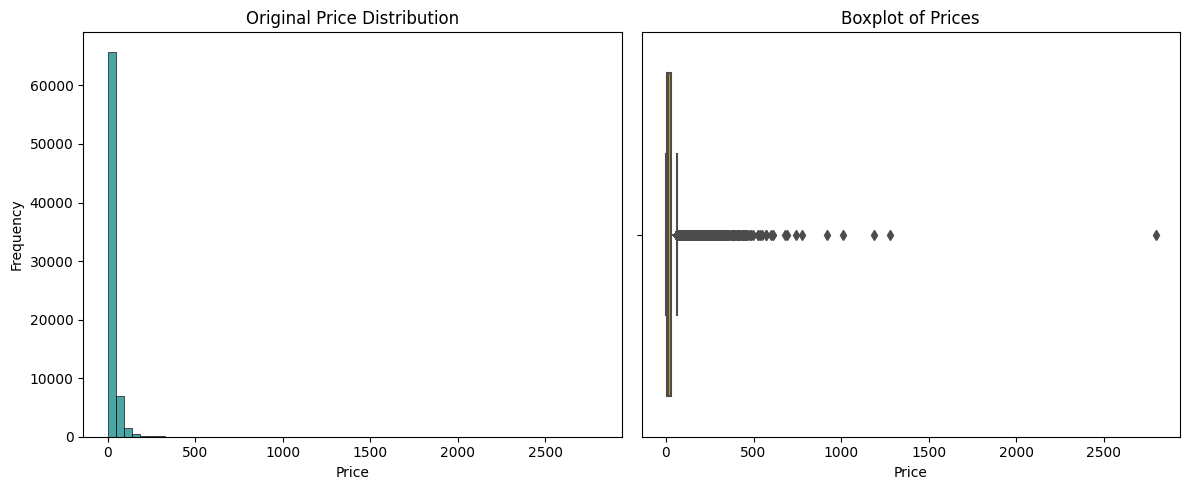

In [7]:
plt.figure(figsize=(12, 5))

# Raw price histogram
plt.subplot(1, 2, 1)
sns.histplot(df.price, bins=60, color='teal', alpha=0.7, edgecolor='black')
plt.title("Original Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Boxplot to detect outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df.price, color='orange')
plt.title("Boxplot of Prices")
plt.xlabel("Price")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


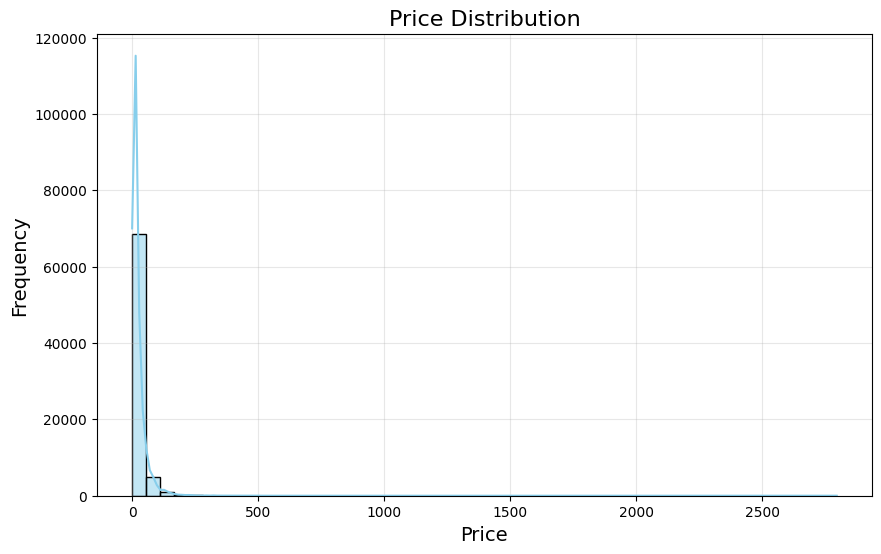

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


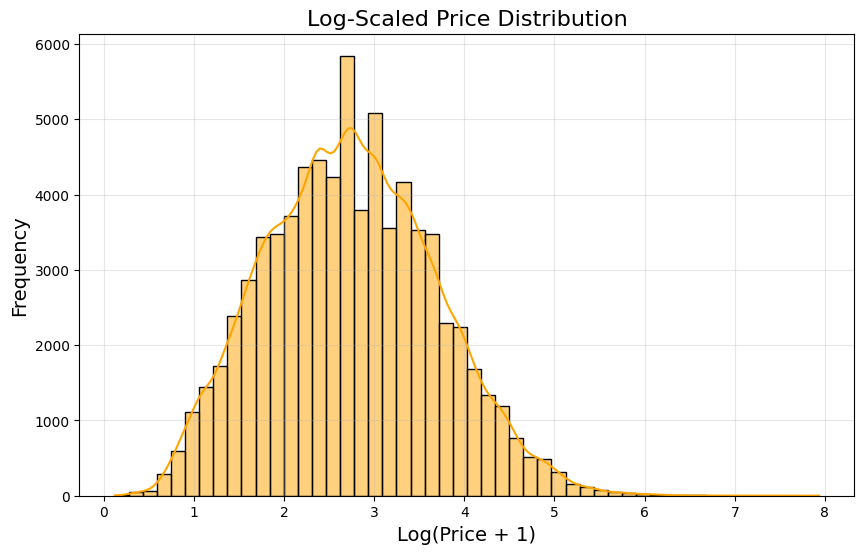

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(df['price']), bins=50, kde=True, color='orange')
plt.title('Log-Scaled Price Distribution', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [10]:
Q1 = np.percentile(df.price, 25)
Q3 = np.percentile(df.price, 75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(f"Price range (IQR-based): {lower_limit:.2f} to {upper_limit:.2f}")

Price range (IQR-based): -25.95 to 61.37


In [11]:
lower_percentile = 1
upper_percentile = 99
lower_clip = np.percentile(df.price, lower_percentile)
upper_clip = np.percentile(df.price, upper_percentile)

print(f"Clipping range (1st–99th percentile): {lower_clip:.2f} to {upper_clip:.2f}")
print(df.price.describe())

Clipping range (1st–99th percentile): 1.32 to 145.25
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


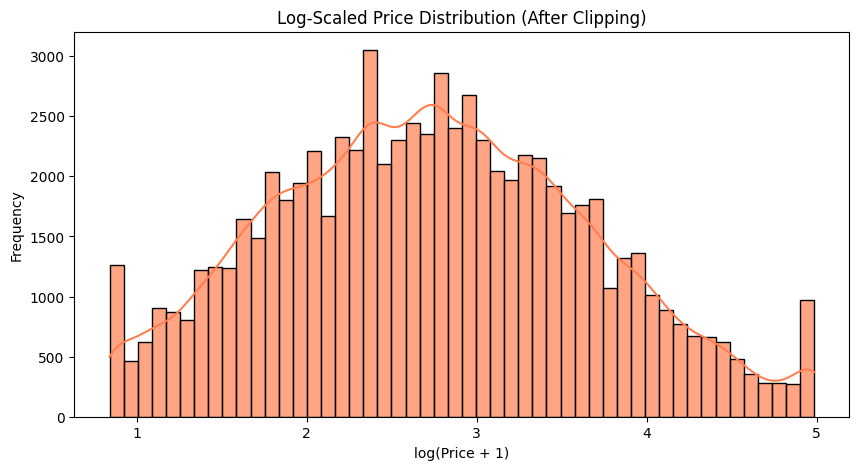

In [12]:
clipped_prices = np.clip(df.price, lower_clip, upper_clip)

plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(clipped_prices), bins=50, kde=True, color='coral', alpha=0.7)
plt.title("Log-Scaled Price Distribution (After Clipping)")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.show()

In [13]:
lower_limit =  1.32
upper_limit = 145.25

# Keep only rows within the desired range
filtered_df = df[(df["price"] >= lower_limit) & (df["price"] <= upper_limit)].copy()

print(f"Original dataset size: {len(df)}")
print(f"After filtering: {len(filtered_df)}")
print(f"Rows removed: {len(df) - len(filtered_df)} ({(1 - len(filtered_df)/len(df))*100:.2f}% removed)")
print(f'Total rows under lower bound: {len(df[(df["price"] < lower_limit)])}')
print(f'Total rows above upper bound: {len(df[(df["price"] > upper_limit)])}')

Original dataset size: 75000
After filtering: 73512
Rows removed: 1488 (1.98% removed)
Total rows under lower bound: 738
Total rows above upper bound: 750


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


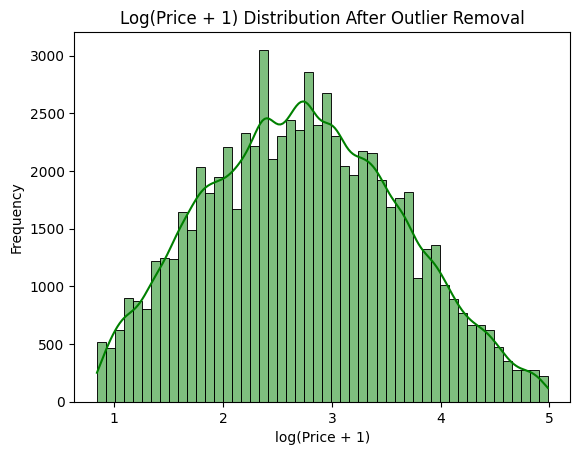

In [14]:
sns.histplot(np.log1p(filtered_df["price"]), bins=50, kde=True, color='green')
plt.title("Log(Price + 1) Distribution After Outlier Removal")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.show()

In [15]:
df = df[(df["price"] >= lower_limit)].copy()
actual_price = df.price
df["log_price"] = np.log1p(df["price"])
df.drop(columns=["price","sample_id"], inplace=True)
total_rows = len(df)
train_rows = int(total_rows * 0.8)
val_rows = total_rows - train_rows

print(f"Final number of training rows: {train_rows}")
print(f"Final number of validation rows: {val_rows}")
print(f"Final number of total rows: {total_rows}")

Final number of training rows: 59409
Final number of validation rows: 14853
Final number of total rows: 74262


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


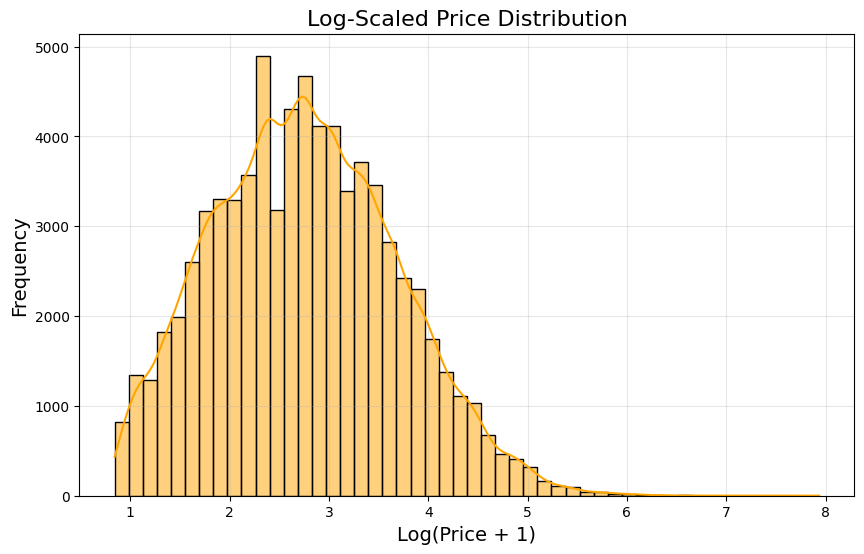

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_price'], bins=50, kde=True, color='orange')
plt.title('Log-Scaled Price Distribution', fontsize=16)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [17]:
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in df['catalog_content']]


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Min tokens: 5
Max tokens: 1822
Median tokens: 139.0
Mean tokens: 204.22788236244648
90th percentile: 508.0
95th percentile: 586.0
99th percentile: 839.0


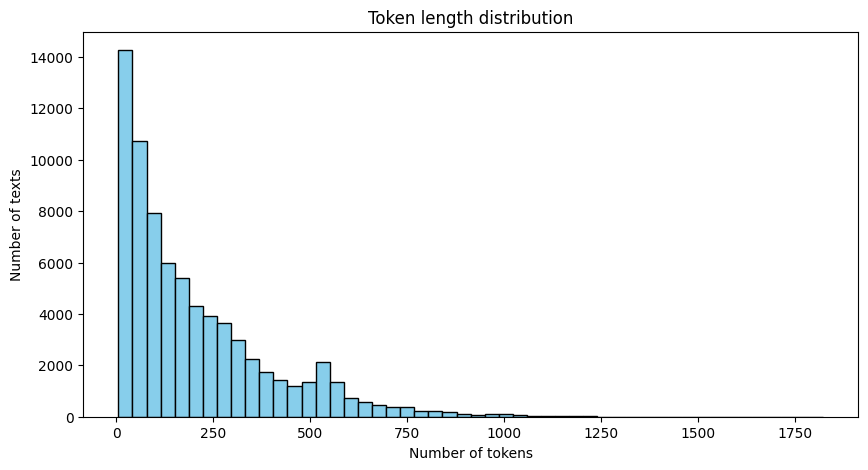

In [18]:
# Convert to NumPy array for convenience
token_lengths = np.array(token_lengths)

# Basic statistics
print("Min tokens:", token_lengths.min())
print("Max tokens:", token_lengths.max())
print("Median tokens:", np.median(token_lengths))
print("Mean tokens:", np.mean(token_lengths))
print("90th percentile:", np.percentile(token_lengths, 90))
print("95th percentile:", np.percentile(token_lengths, 95))
print("99th percentile:", np.percentile(token_lengths, 99))

# Histogram
plt.figure(figsize=(10,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Token length distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of texts")
plt.show()

In [19]:
max_len_optimal = 256

def batch_tokenize(texts, batch_size=256, max_len=512):
    all_input_ids, all_attention_masks = [], []
    for i in range(0, len(texts), batch_size):
        enc = tokenizer(
            texts[i:i+batch_size].tolist(),
            padding='max_length',
            truncation=True,
            max_length=max_len,
            return_tensors='pt'
        )
        all_input_ids.append(enc['input_ids'])
        all_attention_masks.append(enc['attention_mask'])
    return torch.cat(all_input_ids, dim=0), torch.cat(all_attention_masks, dim=0)

input_ids_all, attention_mask_all = batch_tokenize(df['catalog_content'], batch_size=256, max_len=max_len_optimal)

prices_all = torch.tensor(df['log_price'].values, dtype=torch.float32)

In [20]:
train_idx, val_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42)

train_idx_torch = torch.tensor(train_idx, dtype=torch.long)
val_idx_torch = torch.tensor(val_idx, dtype=torch.long)

if not isinstance(input_ids_all, torch.Tensor):
    input_ids_all = torch.tensor(np.array(input_ids_all), dtype=torch.long)
if not isinstance(attention_mask_all, torch.Tensor):
    attention_mask_all = torch.tensor(np.array(attention_mask_all), dtype=torch.long)
if not isinstance(prices_all, torch.Tensor):
    prices_all = torch.tensor(np.array(prices_all), dtype=torch.float32)

# 4. Perform indexing
train_input_ids = input_ids_all[train_idx_torch]
train_attention_mask = attention_mask_all[train_idx_torch]
train_prices = prices_all[train_idx_torch]

val_input_ids = input_ids_all[val_idx_torch]
val_attention_mask = attention_mask_all[val_idx_torch]
val_prices = prices_all[val_idx_torch]

# 5. Pandas indexing for image URLs
train_urls = df['image_link'].iloc[train_idx].tolist()
val_urls = df['image_link'].iloc[val_idx].tolist()

In [21]:
CACHE_DIR = "/kaggle/working/image_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [22]:
def load_image_cached(url, cache_dir=CACHE_DIR):
    """
    Downloads an image from a URL once, caches it as JPEG, 
    and returns a PyTorch tensor ready for ViT.
    """
    # Generate unique filename from URL
    filename = hashlib.md5(url.encode()).hexdigest() + ".jpg"
    filepath = os.path.join(cache_dir, filename)
    
    if os.path.exists(filepath):
        # Load cached image
        img = Image.open(filepath).convert("RGB")
    else:
        # Download image
        try:
            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(filepath, format='JPEG', quality=85)
            img = img_resized
        except Exception:
            # If download fails, return black image
            img = Image.new("RGB", (224,224), color=(0,0,0))
    
    return img

class MultimodalDataset(Dataset):
    def __init__(self, input_ids, attention_mask, urls, prices, image_transform=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.urls = urls
        self.prices = prices
        self.image_transform = image_transform

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        # Load text tensors
        input_id = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        # Load and preprocess image
        image = load_image_cached(self.urls[idx])
        if self.image_transform:
            image = self.image_transform(image)

        # Price
        price = torch.tensor(self.prices[idx], dtype=torch.float32)

        return {
            'input_ids': input_id,
            'attention_mask': attention_mask,
            'pixel_values': image,
            'labels': price.unsqueeze(-1)
        }

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_dataset = MultimodalDataset(
    input_ids=train_input_ids,
    attention_mask=train_attention_mask,
    urls=train_urls,
    prices=train_prices,
    image_transform=image_transform
)

val_dataset = MultimodalDataset(
    input_ids=val_input_ids,
    attention_mask=val_attention_mask,
    urls=val_urls,
    prices=val_prices,
    image_transform=image_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [23]:
def smape(y_true_log, y_pred_log):
    y_true = torch.expm1(y_true_log)
    y_pred = torch.expm1(y_pred_log)
    numerator = torch.abs(y_pred - y_true)
    denominator = (torch.abs(y_true) + torch.abs(y_pred)) / 2 + 1e-7
    return torch.mean(numerator / denominator) * 100

def mae(y_true_log, y_pred_log):
    y_true = torch.expm1(y_true_log)
    y_pred = torch.expm1(y_pred_log)
    return torch.mean(torch.abs(y_pred - y_true))

In [24]:
bert_model = AutoModelForMaskedLM.from_pretrained("answerdotai/ModernBERT-base", trust_remote_code=True)
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Freeze most layers (optional for faster training)
for param in bert_model.parameters():
    param.requires_grad = False
for param in vit_model.parameters():
    param.requires_grad = False

class CrossAttentionFusion(nn.Module):
    def __init__(self, hidden_dim=768, num_heads=4):
        super().__init__()
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, text_emb, image_emb):
        # Query = text, Key/Value = image
        attn_output, _ = self.cross_attention(query=text_emb, key=image_emb, value=image_emb)
        out = self.norm(text_emb + attn_output)
        return out

class MultimodalRegressor(nn.Module):
    def __init__(self, bert_model, vit_model, hidden_dim=768):
        super().__init__()
        self.bert = bert_model.base_model  # take only encoder part
        self.vit = vit_model
        self.fusion = CrossAttentionFusion(hidden_dim=hidden_dim)
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text embeddings
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = text_outputs.last_hidden_state  # [B, seq_len, 768]

        # Image embeddings
        image_outputs = self.vit(pixel_values)
        image_emb = image_outputs.last_hidden_state  # [B, num_patches, 768]

        # Cross Attention Fusion
        fused = self.fusion(text_emb, image_emb)  # [B, seq_len, 768]

        # Mean pooling
        pooled = fused.mean(dim=1)  # [B, 768]

        # Regression output
        price = self.regressor(pooled)
        return price

model = MultimodalRegressor(bert_model, vit_model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad), "trainable parameters")

config.json: 0.00B [00:00, ?B/s]

2025-10-12 11:11:47.375316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760267507.541908      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760267507.593503      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

2823425 trainable parameters


In [25]:
class ModelCheckpoint:
    """
    Saves the best model based on a monitored metric.
    """
    def __init__(self, filepath, monitor='val_loss', mode='min', verbose=True):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        if mode == 'min':
            self.best = float('inf')
        elif mode == 'max':
            self.best = -float('inf')
        else:
            raise ValueError("mode must be 'min' or 'max'")

    def step(self, metric_value, model):
        """
        Call this after each validation step.
        """
        is_improved = False
        if self.mode == 'min' and metric_value < self.best:
            is_improved = True
        elif self.mode == 'max' and metric_value > self.best:
            is_improved = True

        if is_improved:
            if self.verbose:
                print(f"Metric improved ({self.best:.6f} -> {metric_value:.6f}). Saving model to {self.filepath}")
            self.best = metric_value
            torch.save(model.state_dict(), self.filepath)

In [26]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    scaler = torch.cuda.amp.GradScaler()  # initialize scaler

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device).view(-1, 1)

        optimizer.zero_grad()

        # AMP context
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, pixel_values)
            loss = criterion(outputs, labels)

        # Scale and backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels.size(0)

    return running_loss / len(dataloader.dataset)
    

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, pixel_values)
            all_preds.append(outputs)
            all_targets.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    return smape(all_targets, all_preds).item(), mae(all_targets, all_preds).item()

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    
    history = {
        'train_loss': [],
        'val_smape': [],
        'val_mae': []
    }

    checkpoint_cb = ModelCheckpoint("best_model.pth", mode="min")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_smape, val_mae = evaluate(model, val_loader, device)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_smape'].append(val_smape)
        history['val_mae'].append(val_mae)
        
        print(f"Train Loss: {train_loss:.4f} | Val SMAPE: {val_smape:.4f} | Val MAE: {val_mae:.4f}")
        checkpoint_cb.step(val_smape, model)

    print("Training complete!")
    return history

In [27]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss'])+1)
    
    plt.figure(figsize=(16,5))
    
    # Training Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss (Huber)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.legend()

    # Validation Metrics
    plt.subplot(1,2,2)
    plt.plot(epochs, history['val_smape'], label='Val SMAPE')
    plt.plot(epochs, history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Validation Metrics')
    plt.grid(True)
    plt.legend()
    
    plt.show()

In [28]:
def predict_price(model, tokenizer, texts, images, device='cuda', max_len=512):
    """
    texts: list of strings (catalog_content)
    images: torch.Tensor of shape [B, 3, H, W] (preprocessed)
    """
    model.eval()
    
    # Tokenize text
    enc = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    pixel_values = images.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, pixel_values)  # [B, 1]
        log_prices = outputs.squeeze(-1)  # [B]
        prices = torch.expm1(log_prices)  # convert back to real prices
    
    return prices.cpu().numpy()  # return as NumPy array

In [29]:
train_dataset = MultimodalDataset(train_input_ids, train_attention_mask, train_urls, train_prices, image_transform)
val_dataset = MultimodalDataset(val_input_ids, val_attention_mask, val_urls, val_prices, image_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

model = MultimodalRegressor(bert_model, vit_model)

In [ ]:
history = train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device='cuda')

/tmp/ipykernel_37/545779021.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # initialize scaler



Epoch 1/10


Training:   0%|          | 0/1857 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_37/1984239567.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
/tmp/ipykernel_37/1984239567.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  price = torch.tensor(self.prices[idx], dtype=torch.float32)
huggingface/tokenizers: The current pr

In [ ]:
plot_training_curves(history)